# Ads Analysis

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Load Dataset

In [2]:
data = pd.read_csv('ad_table.csv', parse_dates=['date'])
data.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


## Question 1

If you had to identify the 5 best ad groups, which ones would they be? Which metric did you choose to identify the best ad groups? Why? Explain the pros of your metric as well as the possible cons.

In [3]:
# calculate the profit: total_revenue - total_cost
data['profit'] = data['total_revenue'] - data['avg_cost_per_click'] * data['clicked']
data.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad,profit
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1,-1463.48
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1,-1591.75
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1,-1018.28
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1,-1953.94
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1,-1816.55


To identify the 5 best ad groups, there are a lot of different metrics to be used, such as the average click-through-rate, or the average conversion-rate. Here, since the revenue and cost information are given, we will simply use the net profit per shown ad (or unit profit) to find the 5 best ad groups.

In [4]:
def unit_profit(df):
    """ function to calculate the unit profit """
    profit = df['profit'].sum()
    shown = df['shown'].sum()
    val = profit / shown
    
    return val

grouped = data.groupby('ad').apply(unit_profit).reset_index()
grouped = grouped.rename(columns={0: 'unit_profit'})
grouped = grouped.sort_values(by='unit_profit', ascending=False)
grouped.head(10)

,ad,unit_profit
7,ad_group_16,0.020516
11,ad_group_2,0.020116
5,ad_group_14,0.016485
24,ad_group_31,0.005824
19,ad_group_27,0.000725
39,ad_group_9,-0.000069
29,ad_group_36,-0.000560
8,ad_group_17,-0.002144
6,ad_group_15,-0.002293
17,ad_group_25,-0.002576


Based on above calculation, we can see the the top 5 best ad groups are: ad_group_16, ad_group_2, ad_group_14, ad_group_31, ad_group_27.

## Question 2

For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).

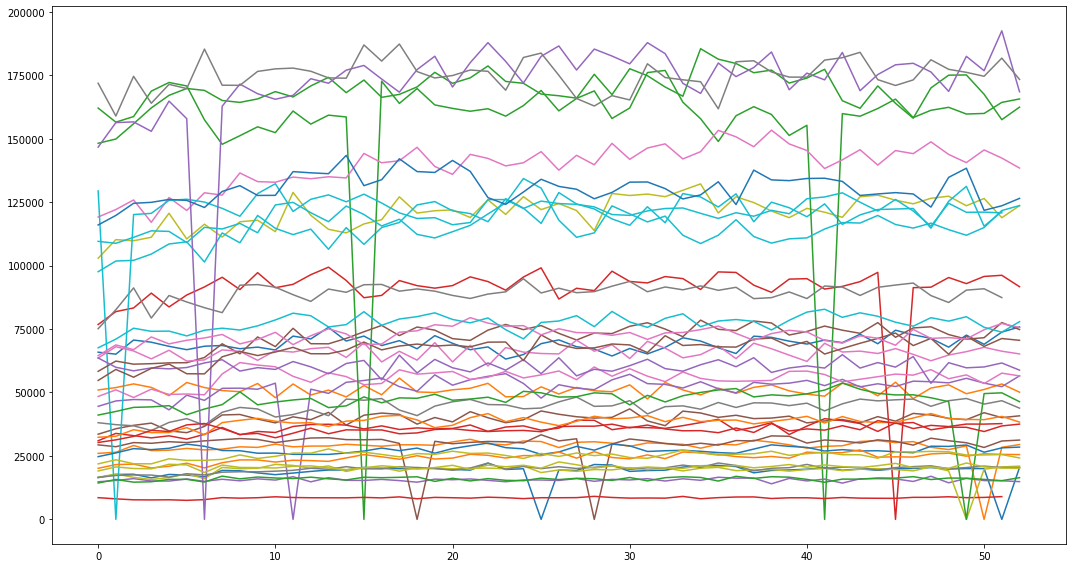

In [5]:
# visualization
fig, ax = plt.subplots(figsize=(15, 8))
for i in range(1, 41):
    ad_group = 'ad_group_' + str(i)
    vals = data[data['ad'] == ad_group].sort_values(by='date')['shown'].values
    ax.plot(vals, label=ad_group)
# ax.legend()
plt.tight_layout()
plt.show()

Clearly, this is a time series prediction problem. R provides a series of good tools to fit time series model and make predictions. This will be finished a little bit later since I am not so familiar with time series modeling in Python.

## Question 3

Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down.

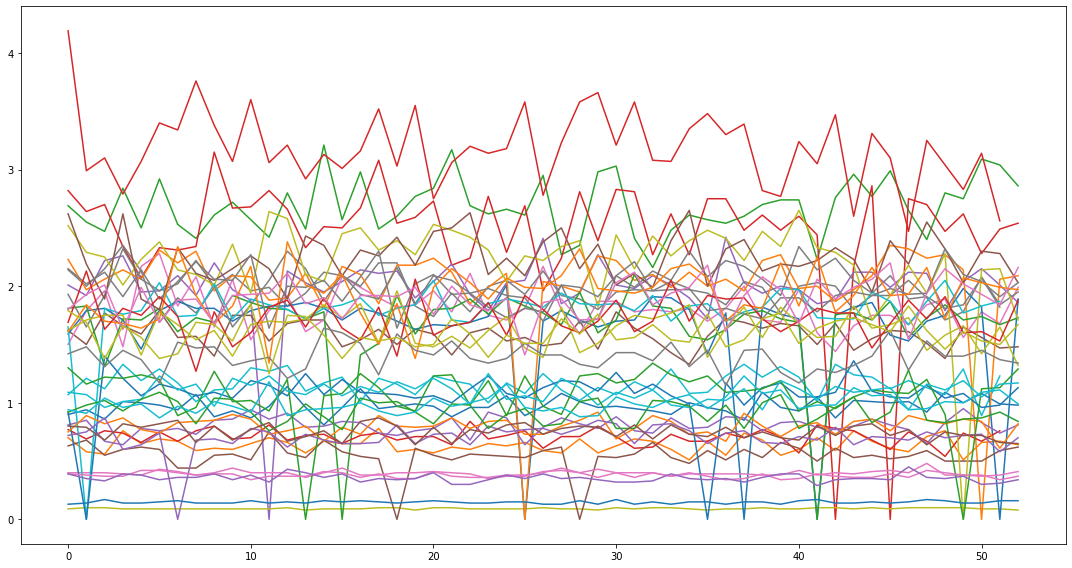

In [6]:
# visualization
fig, ax = plt.subplots(figsize=(15, 8))
for i in range(1, 41):
    ad_group = 'ad_group_' + str(i)
    vals = data[data['ad'] == ad_group].sort_values(by='date')['avg_cost_per_click'].values
    ax.plot(vals, label=ad_group)
# ax.legend()
plt.tight_layout()
plt.show()

In [7]:
def cost_stats(df):
    """ function to calculate the avg_cost_per_click trend """
    tmp = df.sort_values(by='date')['avg_cost_per_click'].values
    ratio = tmp[1:] / tmp[:-1]
    
    ratio_mean = np.mean(ratio)
    ratio_min = np.min(ratio)
    ratio_25 = np.percentile(ratio, 25)
    ratio_50 = np.percentile(ratio, 50)
    ratio_75 = np.percentile(ratio, 75)
    ratio_max = np.max(ratio)
    
    return pd.Series([ratio_mean, ratio_min, ratio_25, ratio_50, ratio_75, ratio_max], 
                     index=['mean', 'min', '25%', '50%', '75%', 'max'])

stats = data.groupby('ad').apply(cost_stats)
stats.head()

,mean,min,25%,50%,75%,max
ad,,,,,,
ad_group_1,1.007436,0.822430,0.930747,0.989999,1.094223,1.282353
ad_group_10,1.011576,0.689922,0.920666,0.976923,1.105323,1.382022
ad_group_11,inf,0.000000,0.957944,1.002941,1.052941,inf
ad_group_12,inf,0.000000,0.945670,1.005051,1.060455,inf
ad_group_13,inf,0.000000,0.958716,1.000015,1.071825,inf


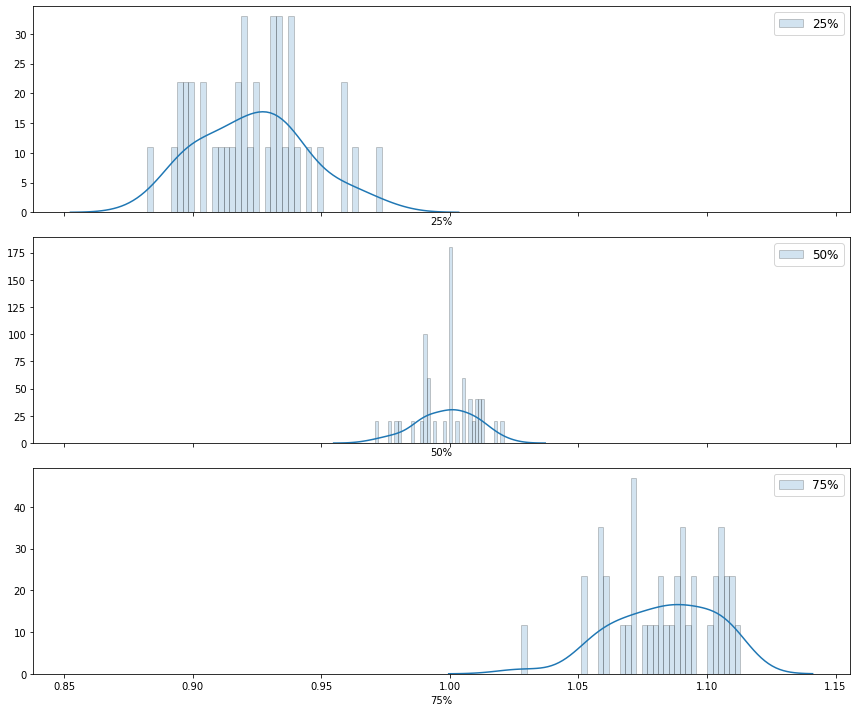

In [8]:
# visualization
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)
sns.distplot(stats['25%'], bins=40, ax=ax[0], label='25%', hist_kws=hist_kws)
ax[0].legend(fontsize=12)
sns.distplot(stats['50%'], bins=40, ax=ax[1], label='50%', hist_kws=hist_kws)
ax[1].legend(fontsize=12)
sns.distplot(stats['75%'], bins=40, ax=ax[2], label='75%', hist_kws=hist_kws)
ax[2].legend(fontsize=12)
plt.tight_layout()
plt.show()


Based on above analysis, we can manually set a series cutoff thresholds to identify the cluster of going up, flat, and going down.